GROUP 8:
- Alexandre Gonçalves (20240738@novaims.unl.pt)
- Bráulio Damba (20240007@novaims.unl.pt)
- Victoria Goon (20240550@novaims.unl.pt)

*** Code below is based off code from the following github -> <a href="https://github.com/fpontejos/Data-Mining-24-25/blob/main/notebooks/lab13_cluster_analysis.ipynb">Data Mining 24-25</a>

In [1]:
# import the main frameworks for dealing with data
import numpy as np
import pandas as pd
# set the max # of columns displayed to 100
pd.set_option('display.max_columns',100)
import matplotlib.pyplot as plt
import random

# suppress any warnings to keep the notebook clean
import warnings
warnings.filterwarnings('ignore')

# import seaborn to help with graphs
import seaborn as sns
sns.set(style="whitegrid")
pd.set_option('display.max_columns', 35) #to display 35 columns
pd.set_option('display.max_rows', 100) #to display 100 rows

# import the cluster methods needed
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances_argmin_min
import matplotlib.cm as cm
from sklearn.base import clone
from collections import Counter
from sklearn.metrics import pairwise_distances

from minisom import MiniSom
from sklearn.manifold import TSNE

from sklearn.decomposition import PCA
from sklearn.utils import resample

from joblib import Parallel, delayed

In [2]:
# import the numerical-encoded preprocessed data and ensure the import was done properly
data = pd.read_csv("minmax_data_preprocessed_wo_cui_day_hr_out.csv")
data.head(1)

,customer_id,vendor_count,product_count,customer_age,is_chain,first_order,last_order,total_spent,order_range,cuisine_variety,total_orders,Early_Morning,Breakfast,Lunch,Snack,Dinner,Late_Night,products_per_orders,chain_per_orders,vendor_per_orders,cuisine_per_orders,spent_per_orders
0,f49ed5489a,2,2,0.553846,0.024096,0.0,0.033708,0.012922,0.044444,0.083333,0.010753,0.0,0.027778,0.0,0.0,0.0,0.0,0.166667,1.0,1.0,1.0,0.085422


In [3]:
# make a copy of the data to have the original untouched
df = data.copy()
df.shape

(6415, 22)

In [4]:
# set the customer ids as the index of the dataframe to prevent it from getting fed to the models
df = df.set_index("customer_id")
df.head(20)

,vendor_count,product_count,customer_age,is_chain,first_order,last_order,total_spent,order_range,cuisine_variety,total_orders,Early_Morning,Breakfast,Lunch,Snack,Dinner,Late_Night,products_per_orders,chain_per_orders,vendor_per_orders,cuisine_per_orders,spent_per_orders
customer_id,,,,,,,,,,,,,,,,,,,,,
f49ed5489a,2,2,0.553846,0.024096,0.0,0.033708,0.012922,0.044444,0.083333,0.010753,0.00,0.027778,0.000000,0.000000,0.000000,0.000000,0.166667,1.000000,1.000000,1.000000,0.085422
eb13ad08ad,4,6,0.492308,0.024096,0.0,0.044944,0.050736,0.055556,0.166667,0.032258,0.04,0.000000,0.036364,0.033333,0.000000,0.000000,0.250000,0.500000,1.000000,0.744565,0.169037
b92ab1eeec,5,6,0.492308,0.060241,0.0,0.056180,0.014375,0.066667,0.333333,0.043011,0.00,0.027778,0.054545,0.000000,0.000000,0.000000,0.200000,1.000000,1.000000,1.000000,0.034670
a9f54fe565,2,4,0.507692,0.036145,0.0,0.123596,0.030034,0.133333,0.083333,0.021505,0.08,0.013889,0.000000,0.000000,0.000000,0.000000,0.222222,1.000000,0.657534,0.659420,0.132986
37c312f839,4,8,0.184615,0.084337,0.0,0.258427,0.011963,0.266667,0.166667,0.064516,0.00,0.000000,0.018182,0.166667,0.019608,0.000000,0.190476,1.000000,0.559687,0.416149,0.018401
543b4d9746,5,17,0.169231,0.144578,0.0,0.258427,0.063143,0.266667,0.250000,0.118280,0.00,0.125000,0.018182,0.033333,0.019608,0.000000,0.236111,1.000000,0.400685,0.318841,0.066622
d5cbe9cd02,7,26,0.246154,0.144578,0.0,0.269663,0.067947,0.277778,0.333333,0.161290,0.00,0.013889,0.145455,0.100000,0.078431,0.000000,0.270833,0.750000,0.422089,0.297554,0.052624
085c69caf5,5,10,0.476923,0.072289,0.0,0.303371,0.031649,0.311111,0.333333,0.053763,0.00,0.041667,0.018182,0.033333,0.019608,0.000000,0.277778,1.000000,0.828767,0.829710,0.067280
9c5d8d6747,5,32,0.184615,0.277108,0.0,0.303371,0.091837,0.311111,0.166667,0.236559,0.00,0.000000,0.127273,0.033333,0.294118,0.000000,0.231884,1.000000,0.195950,0.111531,0.049045


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6415 entries, f49ed5489a to eb13c834e7
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   vendor_count         6415 non-null   int64  
 1   product_count        6415 non-null   int64  
 2   customer_age         6415 non-null   float64
 3   is_chain             6415 non-null   float64
 4   first_order          6415 non-null   float64
 5   last_order           6415 non-null   float64
 6   total_spent          6415 non-null   float64
 7   order_range          6415 non-null   float64
 8   cuisine_variety      6415 non-null   float64
 9   total_orders         6415 non-null   float64
 10  Early_Morning        6415 non-null   float64
 11  Breakfast            6415 non-null   float64
 12  Lunch                6415 non-null   float64
 13  Snack                6415 non-null   float64
 14  Dinner               6415 non-null   float64
 15  Late_Night           6415 no

In [6]:
preference_features = ["cuisine_variety", "order_range","is_chain", 'Early_Morning','Breakfast','Lunch','Snack','Dinner','Late_Night']#, 'Weekday', 'Weekend']

economic_features = ['products_per_orders','chain_per_orders','vendor_per_orders','cuisine_per_orders','spent_per_orders']
# economic_features = ['products_per_orders','chain_per_orders','vendor_per_orders','cuisine_per_orders','spent_per_orders', 
                    #  'CUI_American','CUI_Asian','CUI_Beverages','CUI_Cafe','CUI_Chicken Dishes','CUI_Chinese','CUI_Desserts',
                    #  'CUI_Healthy','CUI_Indian','CUI_Italian','CUI_Japanese','CUI_Noodle Dishes','CUI_OTHER','CUI_Street Food / Snacks','CUI_Thai']

In [7]:
# preference_features = ["cuisine_variety", "order_range","is_chain",'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 
#                        'Early_Morning','Breakfast','Lunch','Snack','Dinner','Late_Night']

# economic_features = ['products_per_orders','chain_per_orders','vendor_per_orders','cuisine_per_orders','spent_per_orders', 
#                      'CUI_American','CUI_Asian','CUI_Beverages','CUI_Cafe','CUI_Chicken Dishes','CUI_Chinese','CUI_Desserts',
#                      'CUI_Healthy','CUI_Indian','CUI_Italian','CUI_Japanese','CUI_Noodle Dishes','CUI_OTHER','CUI_Street Food / Snacks','CUI_Thai']

In [8]:
df_eco = df[economic_features].copy()
df_prf = df[preference_features].copy()

In [9]:
# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    metric='euclidean'
)

In [10]:
# Functions from Lab 09

def get_ss(df, feats):
    """
    Calculate the sum of squares (SS) for the given DataFrame.

    The sum of squares is computed as the sum of the variances of each column
    multiplied by the number of non-NA/null observations minus one.

    Parameters:
    df (pandas.DataFrame): The input DataFrame for which the sum of squares is to be calculated.
    feats (list of str): A list of feature column names to be used in the calculation.

    Returns:
    float: The sum of squares of the DataFrame.
    """
    df_ = df[feats]
    ss = np.sum(df_.var() * (df_.count() - 1))
    
    return ss 


def get_ssb(df, feats, label_col):
    """
    Calculate the between-group sum of squares (SSB) for the given DataFrame.
    The between-group sum of squares is computed as the sum of the squared differences
    between the mean of each group and the overall mean, weighted by the number of observations
    in each group.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    feats (list of str): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column in the DataFrame that contains the group labels.
    
    Returns
    float: The between-group sum of squares of the DataFrame.
    """
    
    ssb_i = 0
    for i in np.unique(df[label_col]):
        df_ = df.loc[:, feats]
        X_ = df_.values
        X_k = df_.loc[df[label_col] == i].values
        
        ssb_i += (X_k.shape[0] * (np.square(X_k.mean(axis=0) - X_.mean(axis=0))) )

    ssb = np.sum(ssb_i)
    

    return ssb


def get_ssw(df, feats, label_col):
    """
    Calculate the sum of squared within-cluster distances (SSW) for a given DataFrame.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    feats (list of str): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column containing cluster labels.

    Returns:
    float: The sum of squared within-cluster distances (SSW).
    """
    feats_label = feats+[label_col]

    df_k = df[feats_label].groupby(by=label_col).apply(lambda col: get_ss(col, feats), 
                                                       include_groups=False)

    return df_k.sum()



In [11]:
# Functions from Lab 09
 
def get_rsq(df, feats, label_col):
    """
    Calculate the R-squared value for a given DataFrame and features.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    feats (list): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column containing the labels or cluster assignments.

    Returns:
    float: The R-squared value, representing the proportion of variance explained by the clustering.
    """

    df_sst_ = get_ss(df, feats)                 # get total sum of squares
    df_ssw_ = get_ssw(df, feats, label_col)     # get ss within
    df_ssb_ = df_sst_ - df_ssw_                 # get ss between

    # r2 = ssb/sst 
    return (df_ssb_/df_sst_)
    

In [12]:
def get_r2_scores(df, feats, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        df_concat = pd.concat([df, 
                               pd.Series(labels, name='labels', index=df.index)], axis=1)  

        r2_clust[n] = get_rsq(df_concat, feats, 'labels' )
    return r2_clust



In [13]:
# Obtaining the R² scores for each cluster solution on demographic variables
# This may take some time to run

r2_scores = {}

r2_scores['kmeans'] = get_r2_scores(df_eco, economic_features, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_eco,                 # data
        economic_features,   # features of perspective
        # use HClust, changing the linkage at each iteration
        hierarchical.set_params(linkage=linkage) 
    )


In [14]:
r2_scores_df = pd.DataFrame(r2_scores)
r2_scores_df

,kmeans,complete,average,single,ward
2,0.337411,0.005649,0.106941,0.000306,0.322717
3,0.544368,0.201919,0.109490,0.001362,0.507400
4,0.647960,0.424265,0.383779,0.004965,0.622282
5,0.702672,0.488786,0.386356,0.006355,0.663915
6,0.750311,0.498141,0.540769,0.006649,0.696719
7,0.774166,0.576126,0.541788,0.008552,0.728841
8,0.795326,0.677801,0.542137,0.008594,0.755858
9,0.813832,0.690234,0.546879,0.008608,0.773248


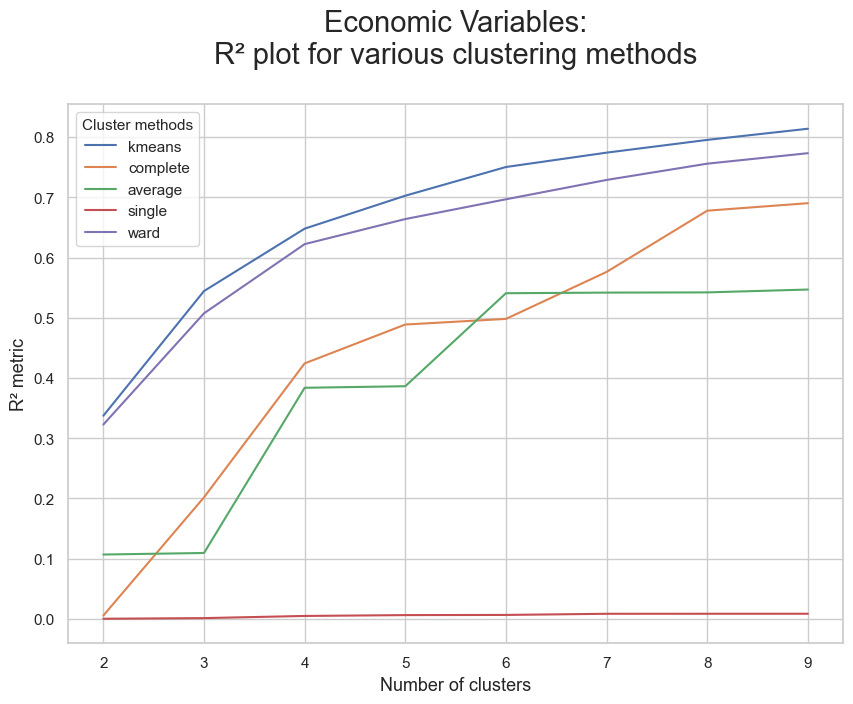

In [15]:
# Visualizing the R² scores for each cluster solution on demographic variables
r2_scores_df.plot.line(figsize=(10,7))

plt.title("Economic Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

In [16]:
# Obtaining the R² scores for each cluster solution on demographic variables
# This may take some time to run

r2_scores = {}

r2_scores['kmeans'] = get_r2_scores(df_prf, preference_features, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_prf,                 # data
        preference_features,   # features of perspective
        # use HClust, changing the linkage at each iteration
        hierarchical.set_params(linkage=linkage) 
    )


In [17]:
r2_scores_df = pd.DataFrame(r2_scores)
r2_scores_df

,kmeans,complete,average,single,ward
2,0.445857,0.011279,0.002076,0.002076,0.418147
3,0.566769,0.176342,0.016485,0.004820,0.534973
4,0.645588,0.178322,0.017785,0.010485,0.601847
5,0.677106,0.455974,0.020059,0.010665,0.633584
6,0.701827,0.458113,0.022247,0.012343,0.660754
7,0.723735,0.459525,0.023368,0.013460,0.686696
8,0.743326,0.465612,0.028885,0.014760,0.711555
9,0.757680,0.468876,0.029455,0.016152,0.726565


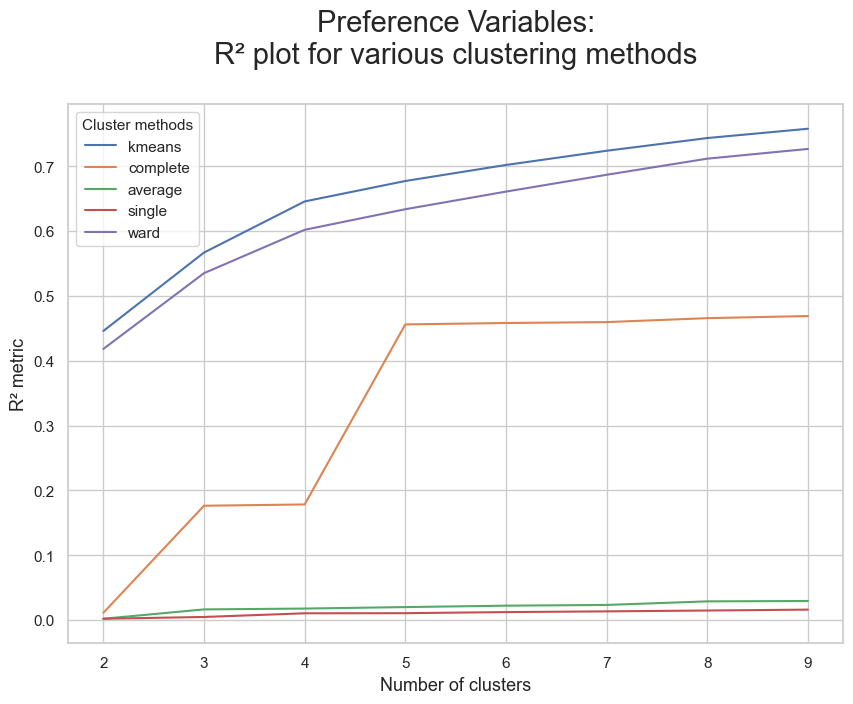

In [18]:
# Visualizing the R² scores for each cluster solution on demographic variables
r2_scores_df.plot.line(figsize=(10,7))

plt.title("Preference Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

In [19]:
eco_elbow = 4

# Applying the right clustering (algorithm and number of clusters) for each perspective
kmeans_eco = KMeans(
    n_clusters=eco_elbow,
    init='k-means++',
    n_init=20,
    random_state=42
)
eco_labels = kmeans_eco.fit_predict(df_eco)

pref_elbow = 4
kmeans_pref = KMeans(
    n_clusters=pref_elbow,
    init='k-means++',
    n_init=20,
    random_state=42
)

pref_labels = kmeans_pref.fit_predict(df_prf)

df['eco_labels'] = eco_labels
df['pref_labels'] = pref_labels
num_of_clusters = eco_elbow + pref_elbow

In [20]:
# Count label frequencies (contigency table)

pd.crosstab(df['eco_labels'],
            df['pref_labels'])

pref_labels,0,1,2,3
eco_labels,,,,
0,657,80,1035,506
1,169,50,582,222
2,468,311,558,587
3,83,291,466,350


In [21]:
# (eco_label, pref_label)
to_merge = [(0,1), (1,0), (1,1), (2,1), (3,0), (3,1)]

In [22]:
metric_features = economic_features + preference_features

In [23]:
metric_features

['products_per_orders',
 'chain_per_orders',
 'vendor_per_orders',
 'cuisine_per_orders',
 'spent_per_orders',
 'cuisine_variety',
 'order_range',
 'is_chain',
 'Early_Morning',
 'Breakfast',
 'Lunch',
 'Snack',
 'Dinner',
 'Late_Night']

In [24]:
# Get centroids of clusters
df_centroids = df.groupby(['eco_labels', 'pref_labels'])\
    [metric_features].mean()

df_centroids

products_per_orders  chain_per_orders  \
eco_labels pref_labels                                          
0          0                       0.217456          0.844253   
           1                       0.226330          0.950932   
           2                       0.213882          0.869804   
           3                       0.215066          0.903801   
1          0                       0.218136          0.382703   
           1                       0.316611          0.088333   
           2                       0.230000          0.242587   
           3                       0.249701          0.200339   
2          0                       0.220013          0.877695   
           1                       0.220832          0.960149   
           2                       0.221496          0.883977   
           3                       0.221419          0.900144   
3          0                       0.225363          0.462324   
           1                       0.259283          0.188754   
           2                       0.261744          0.392385   
           3                       0.273851          0.350229   

                        vendor_per_orders  cuisine_per_orders  \
eco_labels pref_labels                                          
0          0                     0.530687            0.309386   
           1                     0.429621            0.336496   
           2                     0.466274            0.299442   
           3                     0.490576            0.344643   
1          0                     0.441385            0.256172   
           1                     0.490582            0.356815   
           2                     0.427076            0.231890   
           3                     0.473653            0.303826   
2          0                     0.859043            0.597572   
           1                     0.968698            0.889506   
           2                     0.857536            0.570476   
           3                     0.878253            0.662391   
3          0                     0.817905            0.521826   
           1                     0.977571            0.853177   
           2                     0.877190            0.495649   
           3                     0.898751            0.597471   

                        spent_per_orders  cuisine_variety  order_range  \
eco_labels pref_labels                                                   
0          0                    0.047862         0.452689     0.886724   
           1                    0.077660         0.059375     0.184306   
           2                    0.067663         0.172222     0.844863   
           3                    0.067899         0.158267     0.543808   
1          0                    0.077407         0.416667     0.909007   
           1                    0.197600         0.018333     0.188222   
           2                    0.098477         0.160939     0.860939   
           3                    0.121196         0.141517     0.530731   
2          0                    0.042679         0.484152     0.837654   
           1                    0.099030         0.061093     0.076027   
           2                    0.067755         0.256720     0.822561   
           3                    0.070438         0.256104     0.519894   
3          0                    0.087266         0.465863     0.843240   
           1                    0.165841         0.053265     0.091753   
           2                    0.153169         0.213519     0.826729   
           3                    0.165027         0.186190     0.521333   

                        is_chain  Early_Morning  Breakfast     Lunch  \
eco_labels pref_labels                                                 
0          0            0.228696       0.010533   0.055661  0.150297   
           1            0.062199       0.021500   0.011979  0.032727   
           2            0.109155       0.025430   0.030609  0

In [25]:
# Computing the euclidean distance matrix between the centroids
centroid_dists  = pairwise_distances(df_centroids)

df_dists = pd.DataFrame(
    centroid_dists, 
    columns=df_centroids.index, 
    index=df_centroids.index
)

df_dists

eco_labels                     0                                       1  \
pref_labels                    0         1         2         3         0   
eco_labels pref_labels                                                     
0          0            0.000000  0.856349  0.343539  0.505044  0.498085   
           1            0.856349  0.000000  0.681142  0.383188  1.022809   
           2            0.343539  0.681142  0.000000  0.309470  0.583780   
           3            0.505044  0.383188  0.309470  0.000000  0.728364   
1          0            0.498085  1.022809  0.583780  0.728364  0.000000   
           1            1.173739  0.881268  1.055217  0.920999  0.940458   
           2            0.721819  0.994548  0.638709  0.749687  0.357593   
           3            0.845271  0.835653  0.748281  0.711152  0.561158   
2          0            0.468208  0.936041  0.586124  0.630574  0.763143   
           1            1.201690  0.781945  1.108292  0.875312  1.385139   
           2            0.520135  0.830270  0.486756  0.523235  0.781533   
           3            0.691592  0.679464  0.647330  0.512204  0.927406   
3          0            0.560931  1.015341  0.654362  0.722406  0.505013   
           1            1.352725  1.081650  1.281889  1.115748  1.257302   
           2            0.713068  0.992565  0.676430  0.730053  0.611044   
           3            0.874526  0.889486  0.821771  0.746681  0.784410   

eco_labels                                                   2            \
pref_labels                    1         2         3         0         1   
eco_labels pref_labels                                                     
0          0            1.173739  0.721819  0.845271  0.468208  1.201690   
           1            0.881268  0.994548  0.835653  0.936041  0.781945   
           2            1.055217  0.638709  0.748281  0.586124  1.108292   
           3            0.920999  0.749687  0.711152  0.630574  0.875312   
1          0            0.940458  0.357593  0.561158  0.763143  1.385139   
           1            0.000000  0.737679  0.402053  1.230411  1.143331   
           2            0.737679  0.000000  0.349961  0.919313  1.371497   
           3            0.402053  0.349961  0.000000  0.962273  1.176784   
2          0            1.230411  0.919313  0.962273  0.000000  0.942239   
           1            1.143331  1.371497  1.176784  0.942239  0.000000   
           2            1.142617  0.854084  0.889432  0.243568  0.849767   
           3            1.048951  0.977386  0.895349  0.407599  0.550609   
3          0            0.969119  0.616923  0.666840  0.434398  1.083905   
           1            0.713537  1.146739  0.873757  1.157128  0.776597   
           2            0.845865  0.554776  0.577146  0.594006  1.040941   
           3            0.660455  0.704864  0.543836  0.711412  0.828224   

eco_labels                                         3                      \
pref_labels                    2         3         0         1         2   
eco_labels pref_labels                                                     
0          0            0.520135  0.691592  0.560931  1.352725  0.713068   
           1            0.830270  0.679464  1.015341  1.081650  0.992565   
           2            0.486756  0.647330  0.654362  1.281889  0.676430   
           3            0.523235  0.512204  0.722406  1.115748  0.730053   
1          0            0.781533  0.927406  0.505013  1.257302  0.611044   
           1            1.142617  1.048951  0.969119  0.713537  0.845865   
           2            0.854084  0.977386  0.616923  1.146739  0.554776   
           3            0.889432  0.895349  0.666840  0.873757  0.577146   
2          0            0.243568  0.407599  0.434398  1.157128  0.594006   
           1            0.849767  0.550609  1.083905  0.776597  1.040941   
           2            0.000000  0.317755  0.480742  1.082581  0.513336   
           3            0.317755  0.000000  0.

In [26]:
# Merging each low frequency clustering (source) 
# to the closest cluster (target)

source_target = {}

for clus in to_merge:
    # If cluster to merge (source) has not yet been used as target
    if clus not in source_target.values():
        # Add this cluster to source_target map as key
        # Use the cluster with the smallest distance to it as value
        source_target[clus] = df_dists.loc[clus].sort_values().index[1]

source_target

{(0, 1): (0, 3),
 (1, 0): (1, 2),
 (1, 1): (1, 3),
 (2, 1): (2, 3),
 (3, 0): (3, 2),
 (3, 1): (3, 3)}

In [27]:
df_ = df.copy()

# Changing the behavior_labels and product_labels based on source_target
for source, target in source_target.items():
    mask = (df_['eco_labels']==source[0]) & (df_['pref_labels']==source[1])
    df_.loc[mask, 'eco_labels'] = target[0]
    df_.loc[mask, 'pref_labels'] = target[1]



In [28]:
# New contigency table

pd.crosstab(df_['eco_labels'],
            df_['pref_labels'])

pref_labels,0,2,3
eco_labels,,,
0,657,1035,586
1,0,751,272
2,468,558,898
3,0,549,641


In [29]:
# Original contigency table

pd.crosstab(df['eco_labels'],
            df['pref_labels'])

pref_labels,0,1,2,3
eco_labels,,,,
0,657,80,1035,506
1,169,50,582,222
2,468,311,558,587
3,83,291,466,350


In [30]:
# Centroids of the concatenated cluster labels
df_centroids = df.groupby(['eco_labels', 'pref_labels'])\
    [metric_features].mean()
df_centroids

products_per_orders  chain_per_orders  \
eco_labels pref_labels                                          
0          0                       0.217456          0.844253   
           1                       0.226330          0.950932   
           2                       0.213882          0.869804   
           3                       0.215066          0.903801   
1          0                       0.218136          0.382703   
           1                       0.316611          0.088333   
           2                       0.230000          0.242587   
           3                       0.249701          0.200339   
2          0                       0.220013          0.877695   
           1                       0.220832          0.960149   
           2                       0.221496          0.883977   
           3                       0.221419          0.900144   
3          0                       0.225363          0.462324   
           1                       0.259283          0.188754   
           2                       0.261744          0.392385   
           3                       0.273851          0.350229   

                        vendor_per_orders  cuisine_per_orders  \
eco_labels pref_labels                                          
0          0                     0.530687            0.309386   
           1                     0.429621            0.336496   
           2                     0.466274            0.299442   
           3                     0.490576            0.344643   
1          0                     0.441385            0.256172   
           1                     0.490582            0.356815   
           2                     0.427076            0.231890   
           3                     0.473653            0.303826   
2          0                     0.859043            0.597572   
           1                     0.968698            0.889506   
           2                     0.857536            0.570476   
           3                     0.878253            0.662391   
3          0                     0.817905            0.521826   
           1                     0.977571            0.853177   
           2                     0.877190            0.495649   
           3                     0.898751            0.597471   

                        spent_per_orders  cuisine_variety  order_range  \
eco_labels pref_labels                                                   
0          0                    0.047862         0.452689     0.886724   
           1                    0.077660         0.059375     0.184306   
           2                    0.067663         0.172222     0.844863   
           3                    0.067899         0.158267     0.543808   
1          0                    0.077407         0.416667     0.909007   
           1                    0.197600         0.018333     0.188222   
           2                    0.098477         0.160939     0.860939   
           3                    0.121196         0.141517     0.530731   
2          0                    0.042679         0.484152     0.837654   
           1                    0.099030         0.061093     0.076027   
           2                    0.067755         0.256720     0.822561   
           3                    0.070438         0.256104     0.519894   
3          0                    0.087266         0.465863     0.843240   
           1                    0.165841         0.053265     0.091753   
           2                    0.153169         0.213519     0.826729   
           3                    0.165027         0.186190     0.521333   

                        is_chain  Early_Morning  Breakfast     Lunch  \
eco_labels pref_labels                                                 
0          0            0.228696       0.010533   0.055661  0.150297   
           1            0.062199       0.021500   0.011979  0.032727   
           2            0.109155       0.025430   0.030609  0

In [31]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)

hclust_labels = hclust.fit_predict(df_centroids)

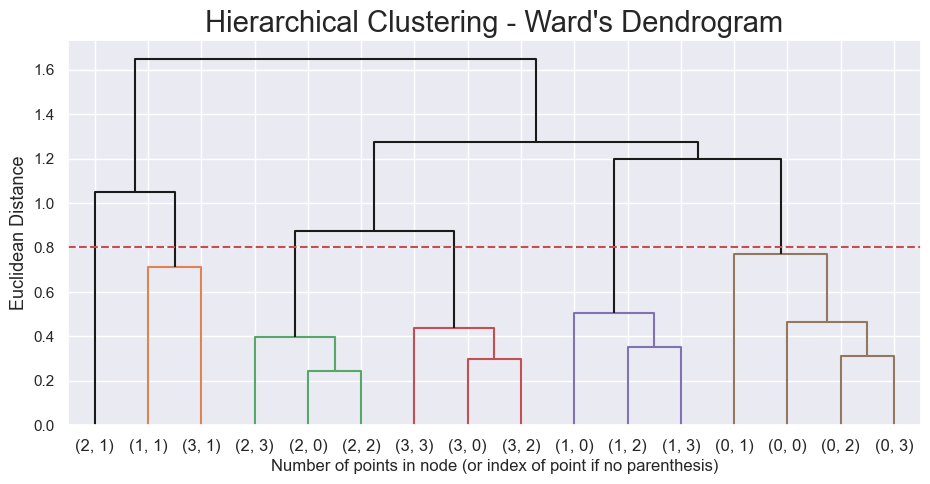

In [32]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned

y_threshold = 0.8
# y_threshold = 3.3

dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df_centroids.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [33]:
# num_of_clusters = 5
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters=num_of_clusters
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

products_per_orders  chain_per_orders  \
eco_labels pref_labels                                          
0          0                       0.217456          0.844253   
           1                       0.226330          0.950932   
           2                       0.213882          0.869804   
           3                       0.215066          0.903801   
1          0                       0.218136          0.382703   
           1                       0.316611          0.088333   
           2                       0.230000          0.242587   
           3                       0.249701          0.200339   
2          0                       0.220013          0.877695   
           1                       0.220832          0.960149   
           2                       0.221496          0.883977   
           3                       0.221419          0.900144   
3          0                       0.225363          0.462324   
           1                       0.259283          0.188754   
           2                       0.261744          0.392385   
           3                       0.273851          0.350229   

                        vendor_per_orders  cuisine_per_orders  \
eco_labels pref_labels                                          
0          0                     0.530687            0.309386   
           1                     0.429621            0.336496   
           2                     0.466274            0.299442   
           3                     0.490576            0.344643   
1          0                     0.441385            0.256172   
           1                     0.490582            0.356815   
           2                     0.427076            0.231890   
           3                     0.473653            0.303826   
2          0                     0.859043            0.597572   
           1                     0.968698            0.889506   
           2                     0.857536            0.570476   
           3                     0.878253            0.662391   
3          0                     0.817905            0.521826   
           1                     0.977571            0.853177   
           2                     0.877190            0.495649   
           3                     0.898751            0.597471   

                        spent_per_orders  cuisine_variety  order_range  \
eco_labels pref_labels                                                   
0          0                    0.047862         0.452689     0.886724   
           1                    0.077660         0.059375     0.184306   
           2                    0.067663         0.172222     0.844863   
           3                    0.067899         0.158267     0.543808   
1          0                    0.077407         0.416667     0.909007   
           1                    0.197600         0.018333     0.188222   
           2                    0.098477         0.160939     0.860939   
           3                    0.121196         0.141517     0.530731   
2          0                    0.042679         0.484152     0.837654   
           1                    0.099030         0.061093     0.076027   
           2                    0.067755         0.256720     0.822561   
           3                    0.070438         0.256104     0.519894   
3          0                    0.087266         0.465863     0.843240   
           1                    0.165841         0.053265     0.091753   
           2                    0.153169         0.213519     0.826729   
           3                    0.165027         0.186190     0.521333   

                        is_chain  Early_Morning  Breakfast     Lunch  \
eco_labels pref_labels                                                 
0          0            0.228696       0.010533   0.055661  0.150297   
           1            0.062199       0.021500   0.011979  0.032727   
           2            0.109155       0.025430   0.030609  0

In [34]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()
cluster_mapper

{(0, 0): 2,
 (0, 1): 6,
 (0, 2): 2,
 (0, 3): 2,
 (1, 0): 0,
 (1, 1): 7,
 (1, 2): 0,
 (1, 3): 0,
 (2, 0): 5,
 (2, 1): 4,
 (2, 2): 5,
 (2, 3): 5,
 (3, 0): 1,
 (3, 1): 3,
 (3, 2): 1,
 (3, 3): 1}

In [35]:
df_ = df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['eco_labels'], row['pref_labels'])
    ], axis=1
)

df_ 

,vendor_count,product_count,customer_age,is_chain,first_order,last_order,total_spent,order_range,cuisine_variety,total_orders,Early_Morning,Breakfast,Lunch,Snack,Dinner,Late_Night,products_per_orders,chain_per_orders,vendor_per_orders,cuisine_per_orders,spent_per_orders,eco_labels,pref_labels,merged_labels
customer_id,,,,,,,,,,,,,,,,,,,,,,,,
f49ed5489a,2,2,0.553846,0.024096,0.0,0.033708,0.012922,0.044444,0.083333,0.010753,0.00,0.027778,0.000000,0.000000,0.000000,0.0,0.166667,1.0,1.000000,1.000000,0.085422,2,1,4
eb13ad08ad,4,6,0.492308,0.024096,0.0,0.044944,0.050736,0.055556,0.166667,0.032258,0.04,0.000000,0.036364,0.033333,0.000000,0.0,0.250000,0.5,1.000000,0.744565,0.169037,3,1,3
b92ab1eeec,5,6,0.492308,0.060241,0.0,0.056180,0.014375,0.066667,0.333333,0.043011,0.00,0.027778,0.054545,0.000000,0.000000,0.0,0.200000,1.0,1.000000,1.000000,0.034670,2,1,4
a9f54fe565,2,4,0.507692,0.036145,0.0,0.123596,0.030034,0.133333,0.083333,0.021505,0.08,0.013889,0.000000,0.000000,0.000000,0.0,0.222222,1.0,0.657534,0.659420,0.132986,2,1,4
37c312f839,4,8,0.184615,0.084337,0.0,0.258427,0.011963,0.266667,0.166667,0.064516,0.00,0.000000,0.018182,0.166667,0.019608,0.0,0.190476,1.0,0.559687,0.416149,0.018401,0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0acd113a52,1,1,0.723077,0.000000,1.0,0.988764,0.008535,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.033333,0.000000,0.0,0.166667,0.0,1.000000,1.000000,0.116660,3,1,3
78601d41a5,1,1,0.430769,0.012048,1.0,0.988764,0.004796,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.019608,0.0,0.166667,1.0,1.000000,1.000000,0.065561,2,1,4
8ce5308c65,1,1,0.476923,0.012048,1.0,0.988764,0.012626,0.000000,0.000000,0.000000,0.00,0.000000,0.018182,0.000000,0.000000,0.0,0.166667,1.0,1.000000,1.000000,0.172580,2,1,4


In [36]:
# Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

df_counts

,0
merged_labels,
0,973
1,899
2,2198
3,291
4,311
5,1613
6,80
7,50


In [37]:
# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts

,merged_labels,0
0,"(1, 3)",973
1,"(3, 3)",899
2,"(0, 3)",2198
3,"(3, 1)",291
4,"(2, 1)",311
5,"(2, 3)",1613
6,"(0, 1)",80
7,"(1, 1)",50


In [38]:
df_counts['eco_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['pref_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])

df_counts

,merged_labels,0,eco_labels,pref_labels
0,"(1, 3)",973,1,3
1,"(3, 3)",899,3,3
2,"(0, 3)",2198,0,3
3,"(3, 1)",291,3,1
4,"(2, 1)",311,2,1
5,"(2, 3)",1613,2,3
6,"(0, 1)",80,0,1
7,"(1, 1)",50,1,1


In [39]:
df_counts.pivot(values=0, index='eco_labels', columns='pref_labels')

pref_labels,1,3
eco_labels,,
0,80,2198
1,50,973
2,311,1613
3,291,899


In [40]:
# Setting df to have the final product, behavior and merged clusters
df = df_.copy()

In [41]:
def cluster_profiles(df, label_columns, figsize, 
                     cmap="tab10",
                     compare_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    
    if compare_titles == None:
        compare_titles = [""]*len(label_columns)
        
    fig, axes = plt.subplots(nrows=len(label_columns), 
                             ncols=2, 
                             figsize=figsize, 
                             constrained_layout=True,
                             squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compare_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, 
                                            label, 
                                            color = sns.color_palette(cmap),
                                            ax=ax[0])



        sns.barplot(x=label, 
                    hue=label,
                    y="counts", 
                    data=counts, 
                    ax=ax[1], 
                    palette=sns.color_palette(cmap),
                    legend=False
                    )

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), 
                              rotation=40,
                              ha='right'
                              )
        
        ax[0].legend(handles, cluster_labels,
                     loc='center left', bbox_to_anchor=(1, 0.5), title=label
                     ) # Adaptable to number of clusters
        
        ax[1].set_xticks([i for i in range(len(handles))])
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
        
        
    
    # plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profiling", fontsize=23)
    plt.show()

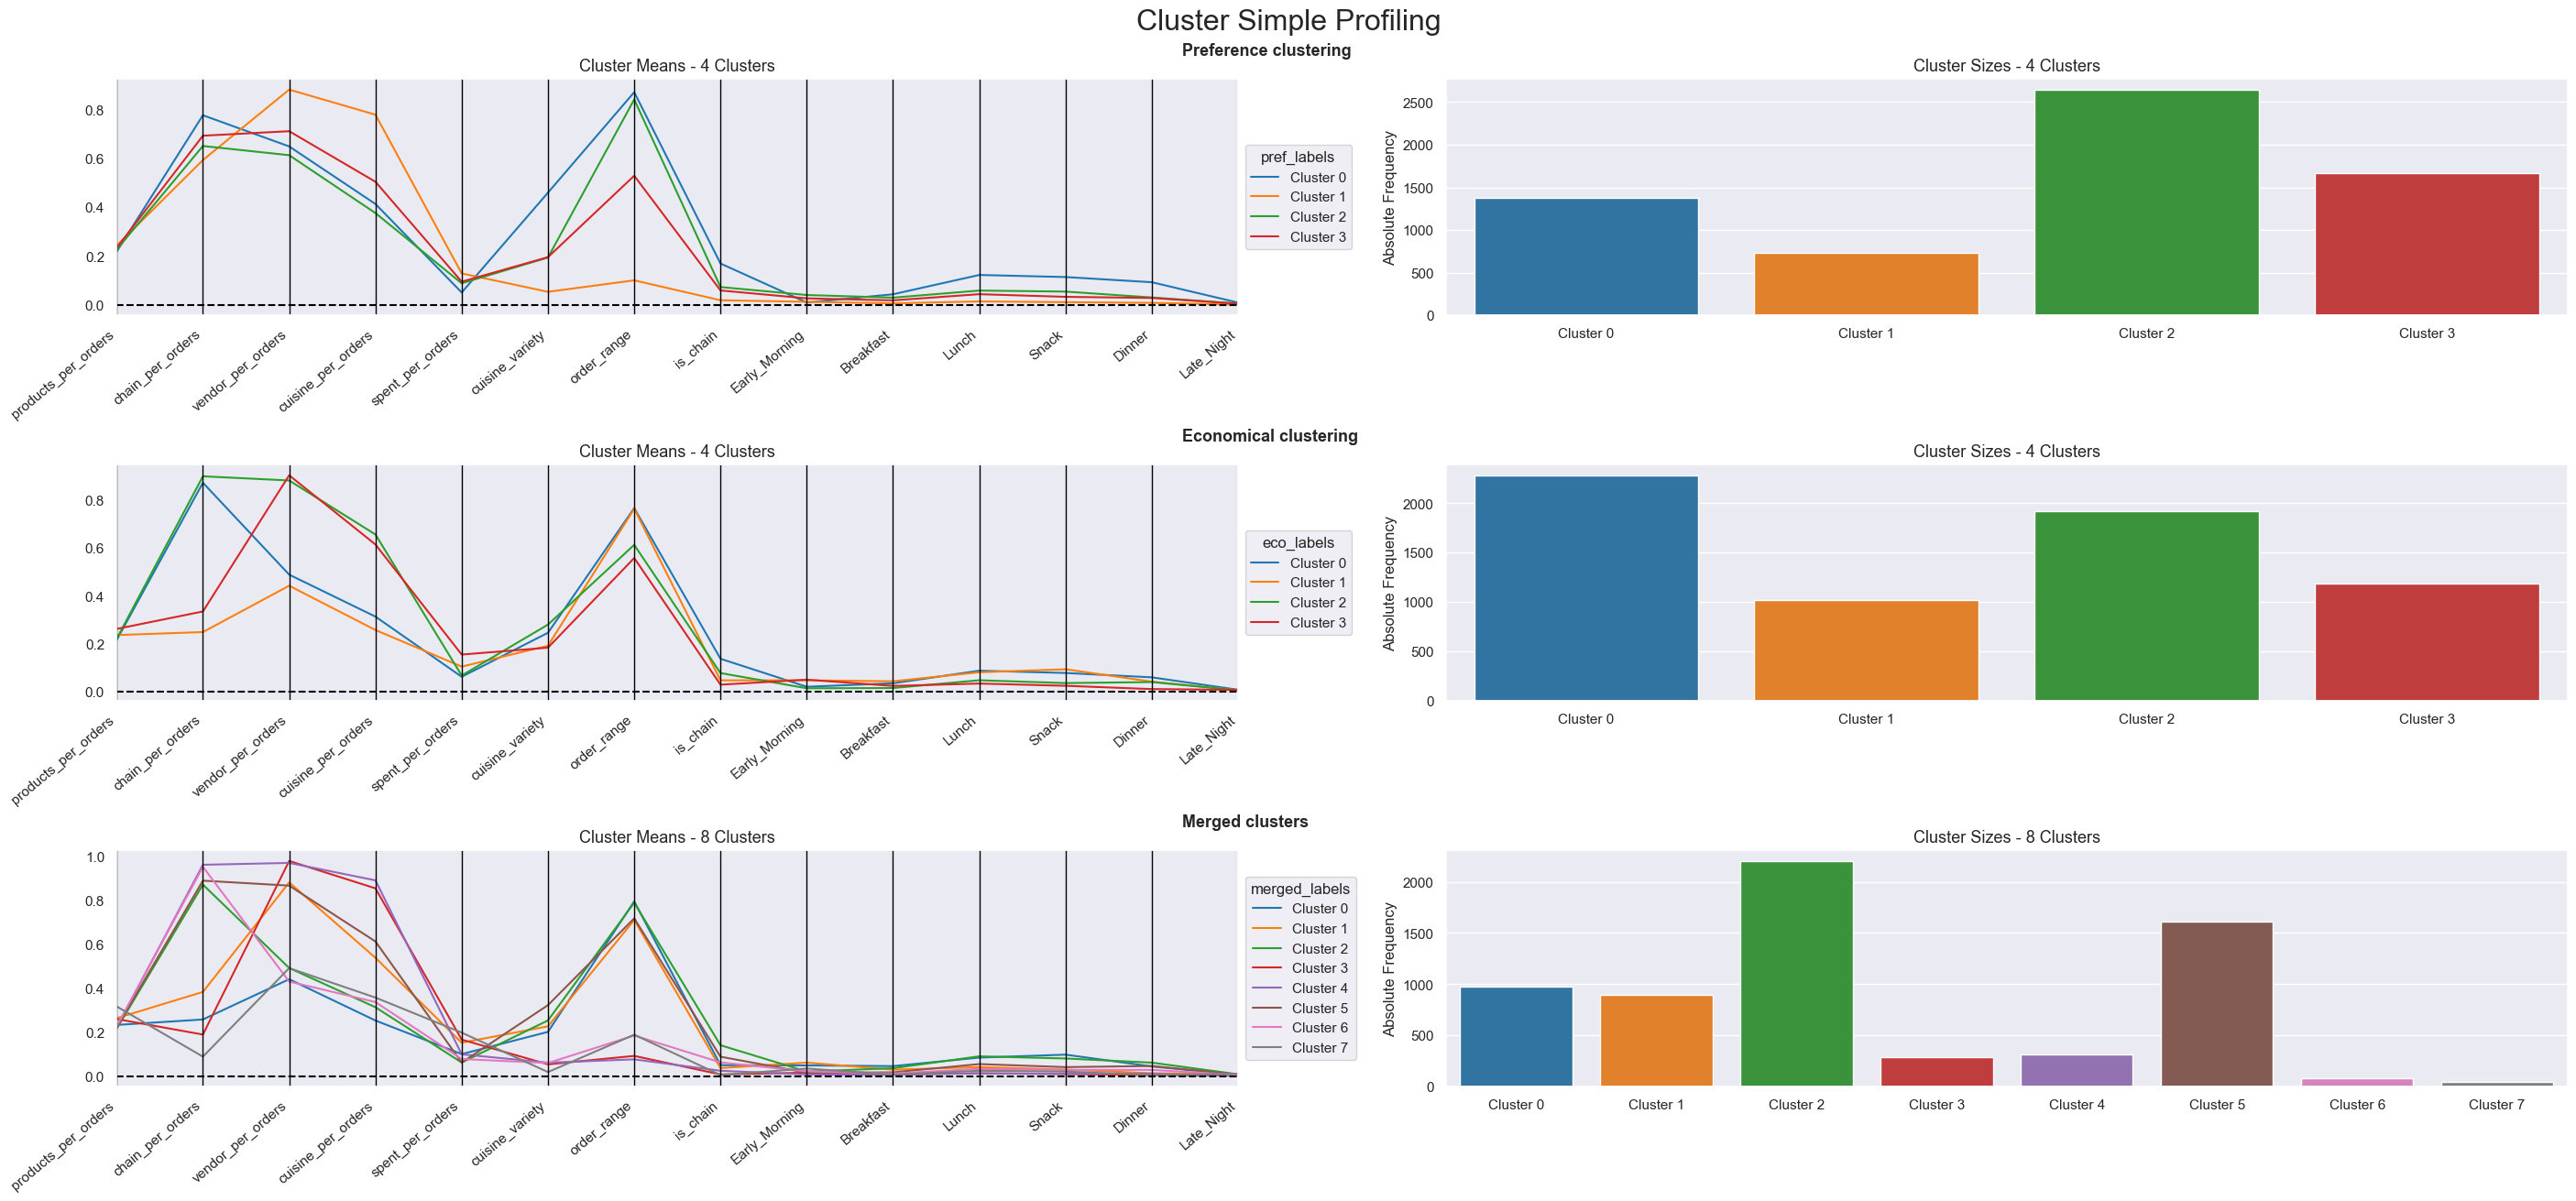

In [42]:
# Profilling each cluster (preference, economical, merged)
cluster_profiles(
    df = df[metric_features + ['pref_labels', 'eco_labels', 'merged_labels']], 
    label_columns = ['pref_labels', 'eco_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compare_titles = ["Preference clustering", "Economical clustering", "Merged clusters"]
)

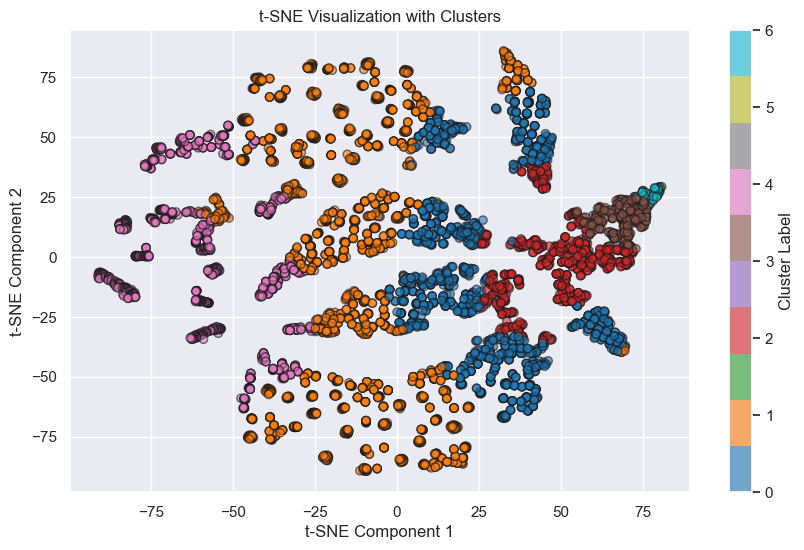

In [43]:
df_data = df.values

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(df_data)

kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(df_data)

# Add the t-SNE results and cluster labels to the DataFrame
df['tsne-2d-one'] = tsne_results[:, 0]
df['tsne-2d-two'] = tsne_results[:, 1]
df['cluster'] = clusters

# Plot the t-SNE results with clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['tsne-2d-one'], df['tsne-2d-two'], c=df['cluster'], alpha=0.6, cmap='tab10', edgecolor='k')
plt.title("t-SNE Visualization with Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(scatter, label='Cluster Label')
plt.show()

In [44]:
df.to_csv("data_clustered_outliers.csv", index=True)